# In conda env openAI
#sudo -H pip install python=3.5  
#sudo -H pip install tensorflow==1.3  
Also Kernel should be openAI  

In [1]:
%%bash
pwd

/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym


# Deep $Q$-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use $Q$-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://github.com/openai/gym). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [3]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# Number of possible actions
print('Number of possible actions:', env.action_space.n, env.action_space)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Number of possible actions: 2 Discrete(2)


/Users/parksoy/Desktop/Soyoung_Udacity_ND_DeepLearning/6.Deep_Reinforcement_Learning/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`.  You can see how many actions are possible from `env.action_space.n`, and to get a random action you can use `env.action_space.sample()`.  Passing in an action as an integer to `env.step` will generate the next step in the simulation.  This is general to all Gym games. 

In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to interact with the environment.

In [4]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break

We can look at the actions and rewards:

In [5]:
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## $Q$-Network

To keep track of the action values, we'll use a neural network that accepts a state $s$ as input.  The output will be $Q$-values for each available action $a$ (i.e., the output is **all** action values $Q(s,a)$ _corresponding to the input state $s$_).

<img src="assets/q-network.png" width=550px>

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

As explored in the lesson, to get the training target, we'll first use the context provided by the state $s$ to choose an action $a$, then simulate the game using that action. This will get us the next state, $s'$, and the reward $r$. With that, we can calculate $\hat{Q}(s,a) = r + \gamma \max_{a'}{Q(s', a')}$.  Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

Below is one implementation of the $Q$-network. It uses two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, activation_fn=None)
            
            #Train with loss (targetQ - Q)^2
            #output has length 2, for two actions. This next line chooses 
            #one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [7]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

We will use the below algorithm to train the network.  For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

You are welcome (and encouraged!) to take the time to extend this code to implement some of the improvements that we discussed in the lesson, to include fixed $Q$ targets, double DQNs, prioritized replay, and/or dueling networks.

## Hyperparameters

One of the more difficult aspects of reinforcement learning is the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [8]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [9]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/parksoy/anaconda3/envs/openAI/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Populate the experience memory

Here we re-initialize the simulation and pre-populate the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [10]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent.

In [11]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                #feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: state.reshape((1, *state.shape))})
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 3.0 Training loss: 1.1599 Explore P: 0.9997
Episode: 2 Total reward: 20.0 Training loss: 1.1814 Explore P: 0.9977
Episode: 3 Total reward: 15.0 Training loss: 1.1074 Explore P: 0.9962
Episode: 4 Total reward: 22.0 Training loss: 1.2165 Explore P: 0.9941
Episode: 5 Total reward: 15.0 Training loss: 1.0962 Explore P: 0.9926
Episode: 6 Total reward: 14.0 Training loss: 1.1756 Explore P: 0.9912
Episode: 7 Total reward: 21.0 Training loss: 1.2184 Explore P: 0.9892
Episode: 8 Total reward: 24.0 Training loss: 1.2125 Explore P: 0.9868
Episode: 9 Total reward: 11.0 Training loss: 1.2785 Explore P: 0.9857
Episode: 10 Total reward: 15.0 Training loss: 1.2947 Explore P: 0.9843
Episode: 11 Total reward: 17.0 Training loss: 1.3504 Explore P: 0.9826
Episode: 12 Total reward: 15.0 Training loss: 1.1414 Explore P: 0.9812
Episode: 13 Total reward: 35.0 Training loss: 1.4642 Explore P: 0.9778
Episode: 14 Total reward: 15.0 Training loss: 1.3605 Explore P: 0.9763
Episode: 15 Tota

Episode: 116 Total reward: 16.0 Training loss: 42.8562 Explore P: 0.8105
Episode: 117 Total reward: 17.0 Training loss: 11.7275 Explore P: 0.8091
Episode: 118 Total reward: 19.0 Training loss: 145.3233 Explore P: 0.8076
Episode: 119 Total reward: 13.0 Training loss: 76.7655 Explore P: 0.8066
Episode: 120 Total reward: 17.0 Training loss: 173.0051 Explore P: 0.8052
Episode: 121 Total reward: 22.0 Training loss: 13.5815 Explore P: 0.8035
Episode: 122 Total reward: 30.0 Training loss: 276.6960 Explore P: 0.8011
Episode: 123 Total reward: 36.0 Training loss: 16.1669 Explore P: 0.7982
Episode: 124 Total reward: 16.0 Training loss: 16.1082 Explore P: 0.7970
Episode: 125 Total reward: 8.0 Training loss: 108.1614 Explore P: 0.7964
Episode: 126 Total reward: 10.0 Training loss: 175.9846 Explore P: 0.7956
Episode: 127 Total reward: 11.0 Training loss: 267.9989 Explore P: 0.7947
Episode: 128 Total reward: 21.0 Training loss: 59.4655 Explore P: 0.7931
Episode: 129 Total reward: 8.0 Training loss: 

Episode: 229 Total reward: 11.0 Training loss: 1.3552 Explore P: 0.6746
Episode: 230 Total reward: 12.0 Training loss: 77.6783 Explore P: 0.6738
Episode: 231 Total reward: 13.0 Training loss: 1.7664 Explore P: 0.6730
Episode: 232 Total reward: 28.0 Training loss: 1.1393 Explore P: 0.6711
Episode: 233 Total reward: 25.0 Training loss: 21.6671 Explore P: 0.6694
Episode: 234 Total reward: 19.0 Training loss: 61.6298 Explore P: 0.6682
Episode: 235 Total reward: 18.0 Training loss: 19.1567 Explore P: 0.6670
Episode: 236 Total reward: 13.0 Training loss: 18.3954 Explore P: 0.6662
Episode: 237 Total reward: 12.0 Training loss: 43.5255 Explore P: 0.6654
Episode: 238 Total reward: 33.0 Training loss: 0.8722 Explore P: 0.6632
Episode: 239 Total reward: 24.0 Training loss: 101.2821 Explore P: 0.6616
Episode: 240 Total reward: 22.0 Training loss: 0.8340 Explore P: 0.6602
Episode: 241 Total reward: 12.0 Training loss: 46.8704 Explore P: 0.6594
Episode: 242 Total reward: 11.0 Training loss: 83.3448 

Episode: 342 Total reward: 57.0 Training loss: 1.6861 Explore P: 0.4646
Episode: 343 Total reward: 55.0 Training loss: 44.7717 Explore P: 0.4621
Episode: 344 Total reward: 73.0 Training loss: 14.0215 Explore P: 0.4588
Episode: 345 Total reward: 54.0 Training loss: 1.4913 Explore P: 0.4564
Episode: 346 Total reward: 28.0 Training loss: 0.9220 Explore P: 0.4551
Episode: 347 Total reward: 40.0 Training loss: 9.7512 Explore P: 0.4534
Episode: 348 Total reward: 33.0 Training loss: 16.1658 Explore P: 0.4519
Episode: 349 Total reward: 23.0 Training loss: 0.9532 Explore P: 0.4509
Episode: 350 Total reward: 37.0 Training loss: 2.2140 Explore P: 0.4493
Episode: 351 Total reward: 34.0 Training loss: 1.5003 Explore P: 0.4478
Episode: 352 Total reward: 54.0 Training loss: 1.5038 Explore P: 0.4454
Episode: 353 Total reward: 34.0 Training loss: 1.4698 Explore P: 0.4439
Episode: 354 Total reward: 41.0 Training loss: 28.8760 Explore P: 0.4422
Episode: 355 Total reward: 72.0 Training loss: 1.8452 Explor

Episode: 455 Total reward: 74.0 Training loss: 1.8690 Explore P: 0.2321
Episode: 456 Total reward: 114.0 Training loss: 1.3526 Explore P: 0.2296
Episode: 457 Total reward: 82.0 Training loss: 83.3309 Explore P: 0.2278
Episode: 458 Total reward: 56.0 Training loss: 2.0740 Explore P: 0.2265
Episode: 459 Total reward: 75.0 Training loss: 83.1855 Explore P: 0.2249
Episode: 460 Total reward: 76.0 Training loss: 1.2271 Explore P: 0.2233
Episode: 461 Total reward: 136.0 Training loss: 2.1526 Explore P: 0.2204
Episode: 463 Total reward: 151.0 Training loss: 1.3347 Explore P: 0.2132
Episode: 464 Total reward: 79.0 Training loss: 1.5838 Explore P: 0.2116
Episode: 465 Total reward: 77.0 Training loss: 1.7893 Explore P: 0.2100
Episode: 466 Total reward: 87.0 Training loss: 1.0680 Explore P: 0.2083
Episode: 467 Total reward: 122.0 Training loss: 83.4252 Explore P: 0.2059
Episode: 468 Total reward: 113.0 Training loss: 85.2230 Explore P: 0.2037
Episode: 469 Total reward: 187.0 Training loss: 1.4557 

Episode: 665 Total reward: 120.0 Training loss: 0.3417 Explore P: 0.0207
Episode: 666 Total reward: 99.0 Training loss: 0.1229 Explore P: 0.0206
Episode: 667 Total reward: 138.0 Training loss: 252.5092 Explore P: 0.0205
Episode: 668 Total reward: 93.0 Training loss: 0.2920 Explore P: 0.0204
Episode: 669 Total reward: 24.0 Training loss: 159.7611 Explore P: 0.0203
Episode: 670 Total reward: 24.0 Training loss: 0.5646 Explore P: 0.0203
Episode: 671 Total reward: 18.0 Training loss: 0.5436 Explore P: 0.0203
Episode: 672 Total reward: 21.0 Training loss: 0.5544 Explore P: 0.0203
Episode: 673 Total reward: 21.0 Training loss: 0.4249 Explore P: 0.0203
Episode: 674 Total reward: 20.0 Training loss: 0.6386 Explore P: 0.0202
Episode: 675 Total reward: 23.0 Training loss: 0.2990 Explore P: 0.0202
Episode: 676 Total reward: 28.0 Training loss: 0.1385 Explore P: 0.0202
Episode: 677 Total reward: 21.0 Training loss: 0.4668 Explore P: 0.0202
Episode: 678 Total reward: 102.0 Training loss: 0.2158 Exp

Episode: 816 Total reward: 13.0 Training loss: 2.8456 Explore P: 0.0123
Episode: 817 Total reward: 16.0 Training loss: 2.4827 Explore P: 0.0123
Episode: 818 Total reward: 18.0 Training loss: 2.7542 Explore P: 0.0123
Episode: 819 Total reward: 15.0 Training loss: 3.5721 Explore P: 0.0123
Episode: 820 Total reward: 14.0 Training loss: 3.2797 Explore P: 0.0123
Episode: 821 Total reward: 15.0 Training loss: 2.6469 Explore P: 0.0123
Episode: 822 Total reward: 17.0 Training loss: 2.1182 Explore P: 0.0123
Episode: 823 Total reward: 18.0 Training loss: 2.6880 Explore P: 0.0123
Episode: 824 Total reward: 25.0 Training loss: 2.3159 Explore P: 0.0123
Episode: 825 Total reward: 22.0 Training loss: 514.5873 Explore P: 0.0122
Episode: 826 Total reward: 29.0 Training loss: 1.2549 Explore P: 0.0122
Episode: 827 Total reward: 49.0 Training loss: 789.9491 Explore P: 0.0122
Episode: 828 Total reward: 81.0 Training loss: 509.1725 Explore P: 0.0122
Episode: 831 Total reward: 99.0 Training loss: 0.8533 Expl

## Visualizing training

Below we plot the total rewards for each episode. The rolling average is plotted in blue.

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

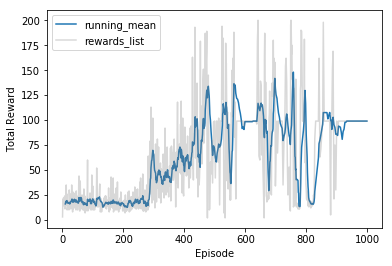

In [15]:
eps, rews = np.array(rewards_list).T  #(ep, total_reward)
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews, label='running_mean')
plt.plot(eps, rews, color='grey', alpha=0.3, label='rewards_list')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()

![png](output_21_1.png)


## Playing Atari Games

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.

In [16]:
env.close()